# Check how to limit the maximum depth

# Method 1: Using grad from Midas

In [1]:
from diffusers.pipelines.stable_diffusion import StableDiffusionPipelineOutput
import torch
from typing import Any, Callable, Dict, List, Optional, Union
from diffusers import StableDiffusionPipeline

class StableDiffusionHackedPipeline(StableDiffusionPipeline):
    @torch.no_grad()
    def __call__(
        self,
        prompt: Union[str, List[str]] = None,
        height: Optional[int] = None,
        width: Optional[int] = None,
        num_inference_steps: int = 50,
        guidance_scale: float = 7.5,
        negative_prompt: Optional[Union[str, List[str]]] = None,
        num_images_per_prompt: Optional[int] = 1,
        eta: float = 0.0,
        generator: Optional[Union[torch.Generator, List[torch.Generator]]] = None,
        latents: Optional[torch.FloatTensor] = None,
        prompt_embeds: Optional[torch.FloatTensor] = None,
        negative_prompt_embeds: Optional[torch.FloatTensor] = None,
        output_type: Optional[str] = "pil",
        return_dict: bool = True,
        callback: Optional[Callable[[int, int, torch.FloatTensor], None]] = None,
        callback_noise: Optional[Callable[[int, int, torch.FloatTensor, torch.FloatTensor, torch.FloatTensor], None]] = None,
        callback_steps: int = 1,
        cross_attention_kwargs: Optional[Dict[str, Any]] = None,
    ):
        # 0. Default height and width to unet
        height = height or self.unet.config.sample_size * self.vae_scale_factor
        width = width or self.unet.config.sample_size * self.vae_scale_factor

        # 1. Check inputs. Raise error if not correct
        self.check_inputs(
            prompt, height, width, callback_steps, negative_prompt, prompt_embeds, negative_prompt_embeds
        )

        # 2. Define call parameters
        if prompt is not None and isinstance(prompt, str):
            batch_size = 1
        elif prompt is not None and isinstance(prompt, list):
            batch_size = len(prompt)
        else:
            batch_size = prompt_embeds.shape[0]

        device = self._execution_device
        # here `guidance_scale` is defined analog to the guidance weight `w` of equation (2)
        # of the Imagen paper: https://arxiv.org/pdf/2205.11487.pdf . `guidance_scale = 1`
        # corresponds to doing no classifier free guidance.
        do_classifier_free_guidance = guidance_scale > 1.0

        # 3. Encode input prompt
        prompt_embeds = self._encode_prompt(
            prompt,
            device,
            num_images_per_prompt,
            do_classifier_free_guidance,
            negative_prompt,
            prompt_embeds=prompt_embeds,
            negative_prompt_embeds=negative_prompt_embeds,
        )

        # 4. Prepare timesteps
        self.scheduler.set_timesteps(num_inference_steps, device=device)
        timesteps = self.scheduler.timesteps

        # 5. Prepare latent variables
        num_channels_latents = self.unet.config.in_channels
        latents = self.prepare_latents(
            batch_size * num_images_per_prompt,
            num_channels_latents,
            height,
            width,
            prompt_embeds.dtype,
            device,
            generator,
            latents,
        )

        # 6. Prepare extra step kwargs. TODO: Logic should ideally just be moved out of the pipeline
        extra_step_kwargs = self.prepare_extra_step_kwargs(generator, eta)

        # 7. Denoising loop
        num_warmup_steps = len(timesteps) - num_inference_steps * self.scheduler.order
        with self.progress_bar(total=num_inference_steps) as progress_bar:
            for i, t in enumerate(timesteps):
                # expand the latents if we are doing classifier free guidance
                latent_model_input = torch.cat([latents] * 2) if do_classifier_free_guidance else latents
                latent_model_input = self.scheduler.scale_model_input(latent_model_input, t)

                # predict the noise residual
                noise_pred = self.unet(
                    latent_model_input,
                    t,
                    encoder_hidden_states=prompt_embeds,
                    cross_attention_kwargs=cross_attention_kwargs,
                ).sample

                # perform guidance
                if do_classifier_free_guidance:
                    noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
                    if callback_noise is not None:
                        callback_noise(i, t, noise_pred_uncond, noise_pred_text, latent_model_input)
                    noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

                # compute the previous noisy sample x_t -> x_t-1
                latents = self.scheduler.step(noise_pred, t, latents, **extra_step_kwargs).prev_sample

                # call the callback, if provided
                if i == len(timesteps) - 1 or ((i + 1) > num_warmup_steps and (i + 1) % self.scheduler.order == 0):
                    progress_bar.update()
                    if callback is not None and i % callback_steps == 0:
                        callback(i, t, latents)

        if output_type == "latent":
            image = latents
            has_nsfw_concept = None
        elif output_type == "pil":
            # 8. Post-processing
            image = self.decode_latents(latents)

            # 9. Run safety checker
            image, has_nsfw_concept = self.run_safety_checker(image, device, prompt_embeds.dtype)

            # 10. Convert to PIL
            image = self.numpy_to_pil(image)
        else:
            # 8. Post-processing
            image = self.decode_latents(latents)

            # 9. Run safety checker
            image, has_nsfw_concept = self.run_safety_checker(image, device, prompt_embeds.dtype)

        # Offload last model to CPU
        if hasattr(self, "final_offload_hook") and self.final_offload_hook is not None:
            self.final_offload_hook.offload()

        if not return_dict:
            return (image, has_nsfw_concept)

        return StableDiffusionPipelineOutput(images=image, nsfw_content_detected=has_nsfw_concept)


In [2]:
import torch

pipe = StableDiffusionHackedPipeline.from_pretrained(
    "/home/wukailu/.cache/huggingface/hub/models--runwayml--stable-diffusion-v1-5/snapshots/39593d5650112b4cc580433f6b0435385882d819",
    torch_dtype=torch.float16).to("cuda")
pipe.enable_xformers_memory_efficient_attention()
pipe.safety_checker = None

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
/home/wukailu/miniconda3/lib/python3.8/site-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(


In [73]:
def print_callback(i, t, noise_pred_uncond, noise_pred_text, latent_model_input):
    # print(i, t, noise_pred_uncond.shape, noise_pred_text.shape, latent_model_input.shape)
    pass

def run(callback, num_inference_steps=50):
    generator = torch.Generator().manual_seed(235)
    ret = pipe(prompt="A bedroom", generator=generator, callback_noise=callback, num_inference_steps=num_inference_steps)
    return ret.images[0]

  0%|          | 0/50 [00:00<?, ?it/s]

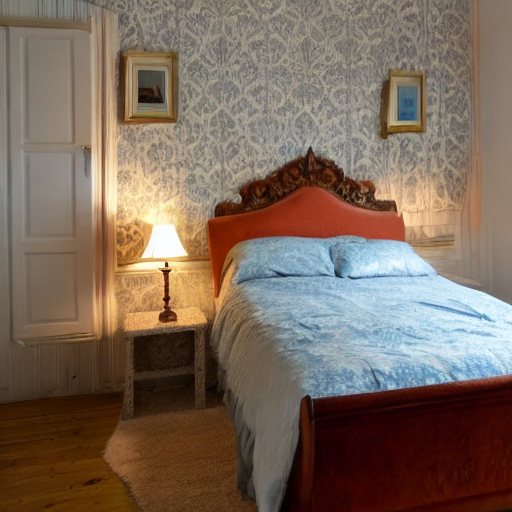

In [74]:
image = run(print_callback)
image

In [37]:
import sys
sys.path.append("/home/wukailu/latent-nerf/src/ControlNet")
from annotator.midas import MidasDetector

midas = MidasDetector()
midas.model = midas.model.eval()

In [38]:
def pred_disp(input_image) -> torch.FloatTensor:
    from annotator.util import HWC3
    with torch.no_grad():
        input_image = HWC3(input_image)
        detected_map: torch.FloatTensor = midas(input_image)
    return detected_map[0]

def get_raw_depth(input_image):
    from einops import rearrange
    with torch.no_grad():
        image_depth = torch.from_numpy(np.array(input_image)).float().cuda()
        image_depth = image_depth / 127.5 - 1.0  # [-1, 1]
        image_depth = rearrange(image_depth, 'h w c -> 1 c h w')
        ret = midas.disp_with_grad(image_depth)
    return ret

In [39]:
def decode_latents(ltt):
    latent = ltt * (1 / pipe.vae.config.scaling_factor)
    image = pipe.vae.decode(latent, return_dict=False)[0]
    image = (image / 2 + 0.5).clamp(0, 1)
    return image

In [42]:
def midas_callback(i, t, noise_pred_uncond, noise_pred_text, latent_model_input):
    pipe.vae.float()
    with torch.enable_grad():
        ltt: torch.Tensor = latent_model_input[:1].detach().float()
        ltt = ltt.requires_grad_(True)
        image_depth = decode_latents(ltt)
        pred = midas.disp_with_grad(image_depth)
        target = torch.ones_like(pred) * (pred.mean().detach())
        loss_func = torch.nn.MSELoss()  # MSE because we assume it follows a normal distribution
        loss = loss_func(pred.flatten(start_dim=1), target.flatten(start_dim=1))
        loss.backward()
    pipe.vae.half()

    grad = ltt.grad * -0.5 * 100 / (100**2) * ((1000 - t) / 1000.)  # divide sigma^2, if depth distribution follows N(target, sigma)
    grad = grad.half()
    sqrt_one_minus_alpha_prod = (1 - pipe.scheduler.alphas_cumprod[t]) ** 0.5
    noise_pred_uncond -= sqrt_one_minus_alpha_prod.to(grad) * grad
    noise_pred_text -= sqrt_one_minus_alpha_prod.to(grad) * grad

    # delta = noise_pred_text - noise_pred_uncond  # mean 0, std 0.01
    # print("noise_pred_uncond: ", noise_pred_uncond.mean(), noise_pred_uncond.std())
    # print("grad: ", grad.mean(), grad.std())

  0%|          | 0/100 [00:00<?, ?it/s]

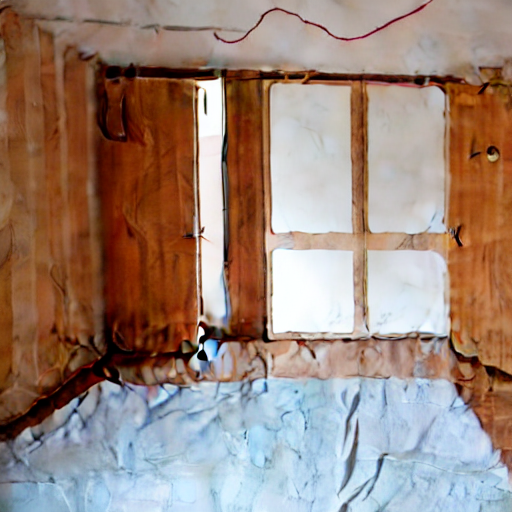

In [43]:
image_guided = run(midas_callback, num_inference_steps=100)
image_guided

  0%|          | 0/300 [00:00<?, ?it/s]

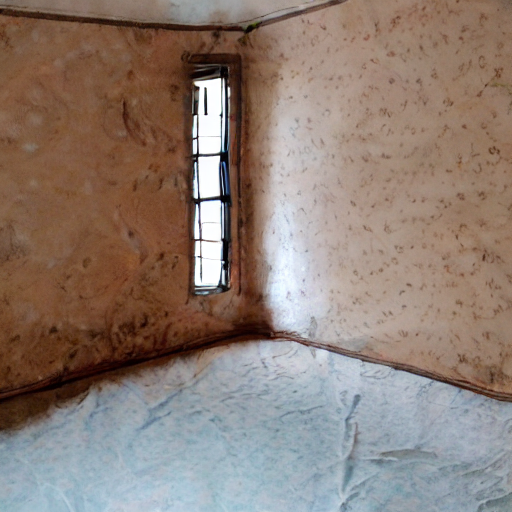

In [44]:
image_guided = run(midas_callback, num_inference_steps=300)
image_guided

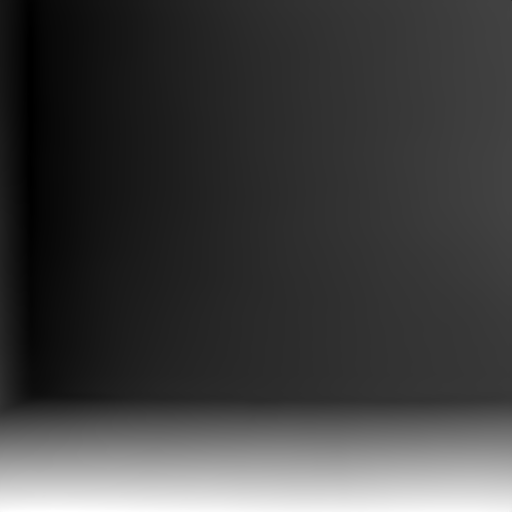

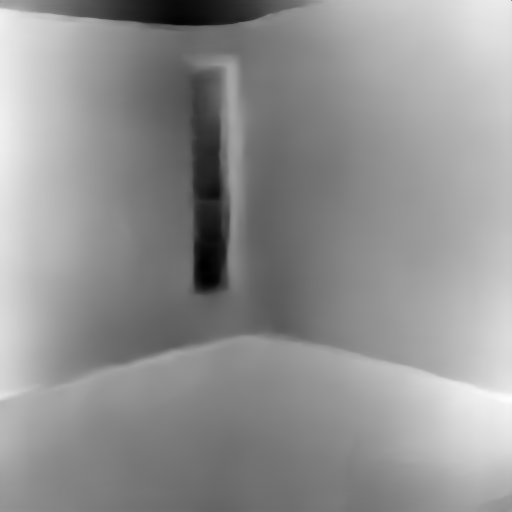

ret_image: 928.89435 611.7152 3083.8872 225.19922
ret_guided: 489.01227 60.868893 650.3205 273.046


In [70]:
import numpy as np
from PIL import Image

display(Image.fromarray(pred_disp(np.array(image))))
display(Image.fromarray(pred_disp(np.array(image_guided))))

ret_image = get_raw_depth(image).cpu().numpy()
print("ret_image:", ret_image.mean(), ret_image.std(), ret_image.max(), ret_image.min())
ret_guided = get_raw_depth(image_guided).cpu().numpy()
print("ret_guided:", ret_guided.mean(), ret_guided.std(), ret_guided.max(), ret_guided.min())

In [71]:
np.save("depth_limit.npy", ret_image)

In [72]:
depth_limit = torch.tensor(np.load("depth_limit.npy"))

In [79]:
def midas_limit_depth(midas_depth_limit):
    def callback(i, t, noise_pred_uncond, noise_pred_text, latent_model_input, target=midas_depth_limit):
        pipe.vae.float()
        with torch.enable_grad():
            ltt: torch.Tensor = latent_model_input[:1].detach().float()
            ltt = ltt.requires_grad_(True)
            image_depth = decode_latents(ltt)
            pred = midas.disp_with_grad(image_depth)
            target = target.to(pred)
            mask = (pred > target).detach()
            loss_func = torch.nn.MSELoss()  # MSE because we assume it follows a normal distribution
            loss = loss_func(pred[mask], target[mask])
            loss.backward()
        pipe.vae.half()

        grad = ltt.grad * -0.5 * 100 / (100**2) * ((1000 - t) / 1000.)  # divide sigma^2, if depth distribution follows N(target, sigma)
        grad = grad.half()
        sqrt_one_minus_alpha_prod = (1 - pipe.scheduler.alphas_cumprod[t]) ** 0.5
        noise_pred_uncond -= sqrt_one_minus_alpha_prod.to(grad) * grad
        noise_pred_text -= sqrt_one_minus_alpha_prod.to(grad) * grad

        # delta = noise_pred_text - noise_pred_uncond  # mean 0, std 0.01
        print("noise_pred_uncond: ", noise_pred_uncond.mean(), noise_pred_uncond.std())
        print("grad: ", grad.mean(), grad.std())
    return callback

  0%|          | 0/100 [00:00<?, ?it/s]

noise_pred_uncond:  tensor(-0.0018, device='cuda:0', dtype=torch.float16) tensor(1.0010, device='cuda:0', dtype=torch.float16)
grad:  tensor(-0.0001, device='cuda:0', dtype=torch.float16) tensor(0.0457, device='cuda:0', dtype=torch.float16)
noise_pred_uncond:  tensor(-0.0014, device='cuda:0', dtype=torch.float16) tensor(1.0020, device='cuda:0', dtype=torch.float16)
grad:  tensor(-6.8724e-05, device='cuda:0', dtype=torch.float16) tensor(0.0551, device='cuda:0', dtype=torch.float16)
noise_pred_uncond:  tensor(-0.0008, device='cuda:0', dtype=torch.float16) tensor(1.0049, device='cuda:0', dtype=torch.float16)
grad:  tensor(-0.0006, device='cuda:0', dtype=torch.float16) tensor(0.0938, device='cuda:0', dtype=torch.float16)
noise_pred_uncond:  tensor(-0.0009, device='cuda:0', dtype=torch.float16) tensor(1.0020, device='cuda:0', dtype=torch.float16)
grad:  tensor(-0.0002, device='cuda:0', dtype=torch.float16) tensor(0.0703, device='cuda:0', dtype=torch.float16)
noise_pred_uncond:  tensor(-0.00

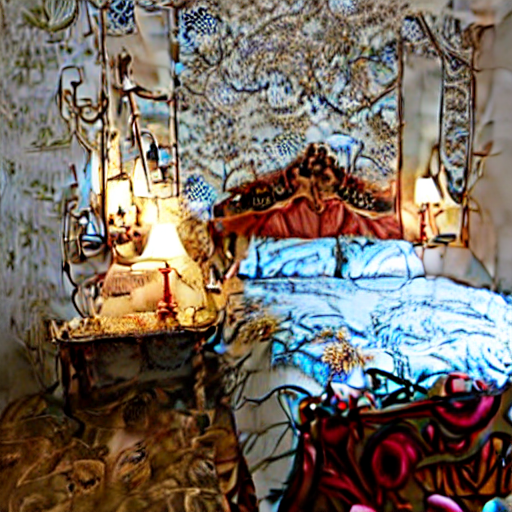

In [80]:
image_limit = run(midas_limit_depth(depth_limit), num_inference_steps=300) # TODO: run this
image_limit

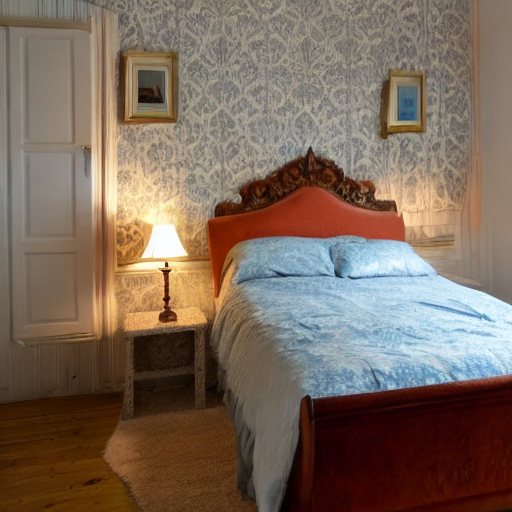

In [81]:
image

# Method 3: extend method 2 to latent diffusion